# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#1: Classification with Supervised Learning
## DUE: 11:59 PM, Tuesday, February 18, 2025

This assignment is a primer on binary classifiction with supervised learning. You will be implementing two classifiers and using them to train and evaluate models on a real world tabular dataset.

**Instructions for accessing the dataset are below**--please make sure to read them. To save you some time, we have handled preprocessing the data for you.

**<font color="red">Please make sure that your Notebook runs (no running cells out of order!) and that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4008_mlh_assignment_1.{filetype}` and submit both a `.ipynb` and `.html` version of your Jupyter notebook.</font>**

In [1]:
import os

import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from ucimlrepo import fetch_ucirepo # uncomment if you are using the ucimlrepo package.
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

## [45 Points] Question 1: Building the Naïve Bayes Classifier

Our goal in Naïve Bayes is to get probabilities a feature vector $\mathbf{x}=(x_1,\ldots{},x_n)$ will belong to $K$ classes $C_k$ via conditional probabilities $P(C_k|\mathbf{x})$. Questions 1.1 - 1.3 will be written (create a `markdown` cell) and 1.4 will be a code implementation.

Starting with posterior $P(C_k|\mathbf{x})$, prior $P(C_k)$, likelihood $P(\mathbf{x}|C_k)$ and evidence $P(\mathbf{x})$, and using the [Chain Rule of Probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)) and the [Law of Total Probability](https://en.wikipedia.org/wiki/Law_of_total_probability), do the following:

#### [5 Points] 1.1: Explain the Naïve Bayes assumption. Why is it "naïve?"

Hint: You should discuss [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence).

<font color="red">Answer 1.1</font>

The Naïve Bayes assumption is that given a specific class label $C_k$, all the RVs making up of the feature vector are independent, which can help us deal with the joint distribution. In the formula view, that is:

$$
P(\mathbf{x} | C_k) = P(X_1, X_2, ..., X_n | C_k) = \prod_i^n P(X_i | C_k)
$$

The assumption is naïve because this assumption can hardly be satisfied in the real world case. We made this assumption just to make it easier to decompose the joint distribution of the feature vector, which can be hard to tackle, into single variant distribution, which can be easier to deal with. (And assuming that all RVs are conditionally independent is the most naïve way to do this decomposition.) It's more of a technique trick but didn't really take into account the real world situation.

#### [10 Points] 1.2: Derive the expression below, starting with Bayes' Theorem:
$$P(C_k|\mathbf{x})=\frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}P(C_k)\prod^{n}_{i=1}P(x_i|C_k)$$

Hints:
- From Bayesian Probability: $\text{posterior}=\frac{\text{prior}\times{\text{likelihood}}}{\text{evidence}}$.
- Think about what the denominator on the expression on the right means in context of the Law of Total Probability
- $P(A,B)=P(B)P(A|B)$
- $P(C_k,\mathbf{x})=P(C_k,x_1, x_2,\ldots{}, x_n)$
- You need the Naïve Bayes Assumption.

<font color="red">Answer 1.2</font>

\begin{aligned}
P(C_k|\mathbf{x}) &= \frac{P(\mathbf{x} | C_{k}) P(C_{k})}{P(\mathbf{x})} \\
&= \frac{P(\mathbf{x} | C_{k}) P(C_{k})}{\sum_k P(C_k) P(\mathbf{x} | C_k)} \\ 
&= \frac{1}{\sum_k P(C_k) P(\mathbf{x} | C_k)} P(C_{k}) P(x_1, x_2, ..., x_n | C_k) \\
&= \frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}P(C_k)\prod^{n}_{i=1}P(x_i|C_k)
\end{aligned}

#### [10 Points] 1.3: We will implement a [Gaussian Naïve Bayes algorithm](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) using [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) for our classification task. Starting from the expression you derviced in Question 1.2, explain how you will build your classifier by deriving the decision rule $\text{argmax}_{y\in\{C_1,\ldots{},C_k\}}\log(C_k|\mathbf{x})$. 

Hints:
- We are trying to select the class $C_k$ that maximizes the posterior probability $P(C_k|\mathbf{x})$.
- What are we assuming about the likelihood of the features? We are assuming that each feature follows a Gaussian distribution *class-dependent* mean and variance.
    - What does this mean with respect to $P(x_i|C_k)$? Think about the Probability Density Function for the Gaussian distribution.
- Since $\frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}$ remains constant, you can ignore it during the maximization step.
- A useful property of logarithms is that $\log(\prod_{i}P(x_i))=\sum_{i}\log(P(x_i))$. This is part of thr eason why we maximize the log-likelihood $\log(P(C_k|\mathbf{x}))$.

<font color="red">Answer 1.3</font>

In the Gaussian Naïve Bayes setting, we assume that each feature follows a Gaussian distribution class-dependent mean and variance. In the formula view, that is:

$$
P(x_i | y) \sim N(\mu_{i,y}, \sigma^2_{i,y})
$$

We use $y$ as the class label, which follows a discrete distribution and $y\in\{C_1,\ldots{},C_k\}$

\begin{aligned}
P(y | \mathbf{x}) &\propto P(\mathbf{x} | y) P(y) = P(y)\prod^{n}_{i=1}P(x_i|y) \\
log(P(y | \mathbf{x})) &= logP(y) + \sum_{i=1}^n \left [-\frac{1}{2\sigma_{i, y}^2}(x_i - \mu_{i,y})^2 - log(\sigma_{i, y}) \right ]+ \text{const.}
\end{aligned}

So here our decision rule is to derive

$$
\text{argmax}_{y\in\{C_1,\ldots{},C_k\}}logP(y) + \sum_{i=1}^n \left [-\frac{1}{2\sigma_{i, y}^2}(x_i - \mu_{i,y})^2 - log(\sigma_{i, y}) \right ]
$$

To further derive the parameters in the formula:

1. To derive the prior distribution

$$
P(y=C_k) = \frac{\sum_j^N\mathbf{1}\{ y_j = C_k\}}{N}
$$

where j is to index the samples and N is the total sample size

2. To derive the feature/class specific gauss distribution parameter $\mu_{i,y}$ and $\sigma_{i,y}^2$

According to the MLE result for Gauss distribution, we can get

\begin{aligned}
\mu_{i,C_k} &= \frac{\sum_{y_j = C_k}x_{i,j}}{\sum_j^N\mathbf{1}\{ y_j = C_k\}} \\
\sigma_{i,C_k}^2 &= \frac{\sum_{y_j = C_k}(x_{i,j} - \mu_{i,C_k})^2}{\sum_j^N\mathbf{1}\{ y_j = C_k\}}
\end{aligned}


#### [20 Points] 1.4: Implement a Naïve Bayes classifier with the skeleton code below.

#### You are allowed to reference the following materials:
- Lecture slides and notes from our course.
- The Wikipedia articles on [Naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), the [Chain Rule of Probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)) and the [Law of Total Probability](https://en.wikipedia.org/wiki/Law_of_total_probability).
- Dr. Kilian Q. Weinberger's [course notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html) and lecture recording.
- Dr. Michael Collin's [notes on Naïve Bayes and Expectation Maximization](http://www.cs.columbia.edu/~mcollins/em.pdf).
- [Scikit-Learn documentation on Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html).

In [2]:
class NaiveBayes:
    
    def __init__(self, epsilon=1e-6):

        self.class_probs = None        # P(C_k), the prior
        self.class_means = None
        self.class_variances = None
        self.classes = None
        self.epsilon = epsilon
    
    def fit(self, X: np.array, y: np.array):

        # X: [n_sample, n_feature] matrix
        # y: [n_sample] array
        assert X.shape[0] == y.shape[0]

        # Number of samples and features
        n_samples, n_features = X.shape
        # Get unique class labels
        self.classes, each_class_num = np.unique(y, return_counts=True)
        n_classes = self.classes.shape[0]
        
        # Use np.zeros() to initialize the following:
        # class_probs with shape n_classes
        # class_means with shape (n_classes, n_features)
        # class_variances with (n_classes, n_features)
        self.class_probs = each_class_num / n_samples
        self.class_means = np.array([X[y == i, :].mean(axis=0) for i in self.classes])
        self.class_variances = np.array([((X[y == i, :] - self.class_means[i,:])**2).mean(axis=0) for i in self.classes])
        
        # X_c: index the features that belong to a class c (hint: you should use the value of y to index X)
        # class_probs: number of rows in X_c / # of samples in X
        # class_means is the mean of X_c along the 0th axis
        # class_var is the variance of X_c aong the 0th axis

        # seems this code is redundant

        # for i, c in enumerate(self.classes):

        #     X_c = None
        #     self.class_probs[i] = None
        #     self.class_means[i, :] = None
        #     self.class_variances[i, :] = None
    
    def _calculate_log_likelihood(self, X):  

        # liklihood: [n_sample, n_cluster]

        # get the number of samples. remember, X.shape = (n_samples, n_features). 
        n_samples = X.shape[0]
        # instantiate the likelihood with an array of zeros of shape (n_samples, n_classes). You can do this using np.zeros()
        likelihood = np.array([(-0.5 / (self.class_variances[i,:] + self.epsilon) * (X - self.class_means[i,:]) ** 2 - 0.5 * np.log(self.class_variances[i,:] + self.epsilon)).sum(axis=1) for i in self.classes]).T
        
        # seems this code is redundant

        # Iterate over the classes
        # for i, _ in enumerate(self.classes):

        #     # get the mean and variance for the current class (by indexing class_means[i,:] and class_variances[i,:])
        #     mean = None
        #     var = None
            
        #     # Calculate the Gaussian Likelihood and populate the [:,i]-th slice of likelihood array with the current class likelihood
        #     likelihood[:, i] = None
        
        return likelihood
    
    def _calculate_log_posterior(self, X) :

        # log(posterior) = log(prior) + log(likelihood)
        prior = np.log(self.class_probs)
        likelihood = self._calculate_log_likelihood(X)
        posterior = prior + likelihood

        return posterior

    def predict(self, X):

        log_posterior = self._calculate_log_posterior(X)
        
        return self.classes[np.argmax(log_posterior, axis=1)]
    
    def predict_proba(self, X):

        log_posterior = self._calculate_log_posterior(X)
        
        posterior = np.exp(log_posterior)
        probabilities = posterior / np.sum(posterior, axis=1, keepdims = True)
        
        return probabilities

# [45 Points] Question 2: Building the Standard Logistic Regression Classifier

We are going to build toward a Logistic Regression classifier. This is one of the most important machine learning models that is used widely in healthcare and other industries.

Unlike the Naïve Bayes classifier, Logistic Regression has an optimization step. If you feel particularly lost in this question, start by reading Sections 5.1, 52, 5.4, and 5.6 in the [Logistic Regression chapter](https://web.stanford.edu/~jurafsky/slp3/5.pdf) in Dr. Jrafsky and Dr. Martin's *Speech and Language Processing*.

#### [10 Points] Question 2.1: Derive the log-loss minimization $L(\hat{y},y)$ for Logistic Regression. Start with the idea that we can model binary labels $P(y=1 \vert \mathbf{x}) \sim \text{Bernoulli}(\sigma(\mathbf{w}^T \mathbf{x}))$, where $\sigma{(\mathbf{x})}=\frac{1}{1+e^{-\mathbf{x}}}$ is the sigmoid function.

Hint: take the following steps.
- Start with $\hat{y}={\sigma(\mathbf{w}^T\mathbf{x})}$
- Bernoulli means that $P(y=1\vert{{\mathbf{x}}})=\hat{y}^{y}(1-\hat{y})^{1-y}$.
- $L(\hat{y},y)=-\log{\left(P(y=1\vert{\mathbf{x}})\right)}$. Replace $\hat{y}$ in terms of $\mathbf{x}$ and expand the expression.

<font color="red">Answer 2.1</font>

\begin{aligned}
L(\hat{y},y) &= -\log{\left(P(y=1\vert{\mathbf{x}})\right)} \\
&= -\log{\hat{y}^{y}(1-\hat{y})^{1-y}} \\
&= -ylog\hat{y} - (1-y)log(1-\hat{y}) \\
&= -ylog \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} - (1-y)log(1- \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} )
\end{aligned}


#### [10 Points] Question 2.2: Get the derivative of $\sigma{(\mathbf{w}^T \mathbf{x})}$ with respect to $w_j\in{}\mathbf{w}$.

Hint: Plug in $\mathbf{w}^T \mathbf{x}$ to $\sigma{(\mathbf{x})}=\frac{1}{1+e^{-\mathbf{x}}}$. Then, either use the quotient rule of partial derivatives:

$$\frac{\partial}{\partial{x}}\frac{f(x,y)}{g(x,y)}=\frac{\frac{\partial{f(x,y)}}{\partial{x}}g(x,y)-f(x,y)\frac{\partial{g(x,y)}}{\partial{x}}}{\left(g(x,y)\right)^2}$$

or express $\sigma{(\mathbf{x})}$ as $(1+e^{-\mathbf{x}})^{-1}$ and use the chain rule.

<font color="red">Answer 2.2</font>

For sigmoid function $\sigma$, we have

$$
\frac{\partial \sigma(x)}{\partial x} = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \frac{e^{-x}}{1+e^{-x}} = \sigma(x)(1-\sigma(x))
$$

Thus we further have

\begin{aligned}
\frac{\partial \sigma(\mathbf{w}^T\mathbf{x})}{\partial{\mathbf{w}}} &= \frac{\partial \sigma(\mathbf{w}^T\mathbf{x})}{\partial{\mathbf{w}^T\mathbf{x}}} \frac{\partial \mathbf{w}^T\mathbf{x}}{\partial \mathbf{w}} \\
&= \sigma(\mathbf{w}^T\mathbf{x})(1-\sigma(\mathbf{w}^T\mathbf{x})) \mathbf{x}
\end{aligned}


#### [10 Points] Question 2.3: Derive a gradient descent update to optimize for $\mathbf{w}$.

Hint: This is the derivative of the expression you derived from Question 2.1 ($L(\hat{y},y)$) with respect to $w_j\in{\mathbf{w}}$.

<font color="red">Answer 2.3</font>

\begin{aligned}
\frac{\partial L(\hat{y}, y)}{\partial \mathbf{w}} &= \frac{\partial L(\hat{y}, y)}{\partial\hat{y}} \frac{\partial \hat{y}}{\partial \mathbf{w}} \\
&= \frac{\partial -ylog\hat{y} - (1-y)log(1-\hat{y})}{\partial \hat{y}} \frac{\partial \sigma(\mathbf{w}^T\mathbf{x})}{\partial \mathbf{w}} \\
&= \left(-\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}} \right) \sigma(\mathbf{w}^T\mathbf{x})(1-\sigma(\mathbf{w}^T\mathbf{x})) \mathbf{x} \\
&= (\hat{y} - y)\mathbf{x}
\end{aligned}


#### [15 Points] Question 2.4: Build a Logistic Regression classifier with the skeleton code below.

#### You are allowed to reference the following materials:
- Lecture slides and notes from our course.
- The [Logistic Regression chapter](https://web.stanford.edu/~jurafsky/slp3/5.pdf) in Dr. Jrafsky and Dr. Martin's *Speech and Language Processing*.
- The Wikipedia articles on [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression).
- Dr. Kilian Q. Weinberger's [course notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote06.html) and lecture recording.
- [Scikit-Learn documentation on Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


In [3]:
class LogisticRegression :

    # you will populate self.classes, self.w with the dimensions of the training data in the self.fit() functionj
    # losses will be populated during training with the self.fit() function.
    def __init__(self, eps=10e-6) :

        self.classes = None
        self.w = None
        self.losses = []
        self.eps = eps

    def sigmoid(self, x) :

        return 1 / (1 + np.exp(-x))

    # This should be your answer from question 2.1
    # Adding a small eps value in logs (e.g. np.log(y + eps)) can help with numeric stability.
    # you can divide the loss by the number of samples i.e. len(y_true)
    def loss(self, y_true, y_pred):

        assert y_true.shape == y_pred.shape

        return (- y_true * np.log(y_pred + self.eps) - (1 - y_true) * np.log1p(-y_pred + self.eps)).mean()
    
    def predict_proba(self, x) :
        y_pred_probs = self.sigmoid(np.matmul(x, self.w))
        y_pred_probs = np.column_stack([1 - y_pred_probs, y_pred_probs])
        return y_pred_probs

    def predict(self, x) :
        
        return np.argmax(self.predict_proba(x), axis = 1)
    
    def fit(self, x: np.array, y_true: np.array, eta = 0.1, C = 0.01, n_iterations = 10000) :

        # here eta is the learning rate
        # C is the coefficient penalty
        # x: [n_sample, n_feature]
        # y_true: [n_sample]

        # if you labels is of shape (n_samples,) rather than (n_samples,2), this loop will handle it
        # don't see the point of change the shape of the y_true
        # if len(y_true.shape) == 1 :
        #     y_true = np.expand_dims(y_true, axis = -1)
        #     y_true = np.column_stack([1-y_true, y_true])

        # Number of samples and features
        n_features = x.shape[1]
        # Get unique class labels
        self.classes = np.unique(y_true)
        n_classes = self.classes.shape[0]
        self.w = np.random.randn(n_features, 1)

        self.losses = []
        for _ in range(n_iterations) :

            y_pred = self.sigmoid(x @ self.w).flatten()
            # the gradient should be your answer from question 2.3
            gradient = ((y_pred - y_true).reshape(-1,1) * x).mean(axis=0)
            self.losses.append(self.loss(y_true, y_pred).item())
            self.w -= eta * gradient.reshape(-1,1)

# [10 Points] Question 3: Training and Evaluating the Classifiers

Now that you have done the hard work of building your models, it's time to train!

We have already supplied you with starter code to get your `X_train`, `y_test`, etc (don't worry, you'll get plenty of opportunity for data cleaning and processing in later assignments). Instantiate model objects for both `NaiveBayes` and `LogisticRegression` and use their respective `.fit()`, `.predict_proba()`, and `.predict()` methods to train your models and generate predictions on the test set.

As we discussed in the preamble, it's important to generate distributional estimates of your performance (rather than point estimates). There are several ways to get these confidence intervals; however, we are going to consider a fairly lightweight method of doing this by resampling the test set to generate our metrics--if you find this task daunting, we suggest starting with the [definition of bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) (e.g. how do we sample with replacement with `numpy`), what a 95% [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) is supposed to represent, and [the primer by Dr. Sebastian Rashka](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html) (specifically [Method 3](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html#method-3-bootstrapping-the-test-set-predictions)).

#### [10 Points] 3.1: Using the starter code below, train both a `NaiveBayes` and `LogisticRegression` model and generate 95% confidence intervals for Accuracy, AUPRC, and AUROC by bootstrapping the test set. You may use `sklearn.metrics` to generate your scores.

In [4]:
# STARTER CODE

# If you downloaded the data and label files locally, replace the file paths below.
DATA_PATH, LABEL_PATH = os.path.join('data', 'heart_disease_data.csv'), os.path.join('data', 'heart_disease_labels.csv')

if os.path.isfile(DATA_PATH) and os.path.isfile(LABEL_PATH) :

    X = pd.read_csv(DATA_PATH)
    y = pd.read_csv(LABEL_PATH)

# If you are using the UCI ML Repo package instead:
else :

    from ucimlrepo import fetch_ucirepo

    heart_disease = fetch_ucirepo(id = 45)
    X = heart_disease.data.features
    y = heart_disease.data.targets

# Feature descriptions from the UCI Machine Learning Repository documentation:
# cp (categorical): chest pain type (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
# trestbps (integer): resting blood pressure (in mm Hg on admission to the hospital)
# chol (integer): serum cholestoral in mg/dl
# fbs (categorical): (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
# restecg (categorical): resting electrocardiographic results (0: normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
# thalach (integer): maximum heart rate achieved
# exang (categorical): exercise induced angina (1 = yes; 0 = no)
# oldpeak (integer): ST depression induced by exercise relative to rest
# slope (categorical): the slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
# ca (integer): number of major vessels (0-3) colored by flourosopy
# thal (categorical): 3 = normal; 6 = fixed defect; 7 = reversable defect

# Convert labels to binary values.
y = y['num'].to_numpy()
y[y!=0] = 1

data_type_by_columns = {"age":"integer",
                        "sex":"categorical",
                        "cp": "categorical",
                        "trestbps": "integer",
                        "chol": "integer",
                        "fbs": "categorical",
                        "restecg": "categorical",
                        "thalach": "integer",
                        "exang": "categorical",
                        "oldpeak": "integer",
                        "slope": "categorical",
                        "ca": "integer",
                        "thal": "categorical"}

columns_to_convert_to_dummies = [column_name for column_name,data_type in data_type_by_columns.items() if (data_type == 'categorical') and len(set(X[column_name])) > 2]

for column_name in columns_to_convert_to_dummies :
    current_dummies = pd.get_dummies(X[column_name], prefix = column_name)
    X = pd.concat([X, current_dummies], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f'Label counts: train {Counter(y_train)}, test {Counter(y_test)}')

median_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
median_imputer.fit(X_train)
X_train, X_test = median_imputer.transform(X_train), median_imputer.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

Label counts: train Counter({np.int64(0): 129, np.int64(1): 113}), test Counter({np.int64(0): 35, np.int64(1): 26})


In [5]:
def bootstrap_test_from_pred(label, pred_prob, bootstrap_num=200, bootstrap_sample_size=1000, **kwargs):
    assert pred_prob.shape[0] == label.shape[0]

    pred = np.argmax(pred_prob, axis = 1)
    idx = np.arange(label.shape[0])

    metric_dict = {k:[] for k in kwargs.keys()}

    for i in range(bootstrap_num):
        bootstrap_sample_idx = np.random.RandomState(seed=i).choice(idx, size=bootstrap_sample_size, replace=True)
        bootstrap_label = label[bootstrap_sample_idx]
        bootstrap_pred = pred[bootstrap_sample_idx]
        bootstrap_pred_prob = pred_prob[bootstrap_sample_idx, :]

        for metric, func in kwargs.items():
            if "AUC" in metric:
                metric_dict[metric].append(func(bootstrap_label, bootstrap_pred_prob[:,1]))
            else:
                metric_dict[metric].append(func(bootstrap_label, bootstrap_pred))
    
    return metric_dict

### NaiveBayes

In [6]:
naivebayes = NaiveBayes()
naivebayes.fit(X_train, y_train)
naivebayes_pred_prob = naivebayes.predict_proba(X_test)

In [7]:
test_metrics = bootstrap_test_from_pred(label=y_test, pred_prob=naivebayes_pred_prob, bootstrap_sample_size=y_test.shape[0], PRAUC=average_precision_score, ROAUC=roc_auc_score, Accuracy=accuracy_score)

In [8]:
method_name = "Naive Bayes"
print(f"Bootstrap Metrics Evaluation for {method_name}\n")
for metric, metric_res in test_metrics.items():
    print(f"{metric}:")
    print(f"Mean: {np.mean(metric_res):.3f}")
    print(f"95% CI Upper: {np.percentile(metric_res, 97.5):.3f}")
    print(f"95% CI Lower: {np.percentile(metric_res, 2.5):.3f}")
    print("*"*15)

Bootstrap Metrics Evaluation for Naive Bayes

PRAUC:
Mean: 0.845
95% CI Upper: 0.942
95% CI Lower: 0.719
***************
ROAUC:
Mean: 0.844
95% CI Upper: 0.936
95% CI Lower: 0.720
***************
Accuracy:
Mean: 0.805
95% CI Upper: 0.902
95% CI Lower: 0.705
***************


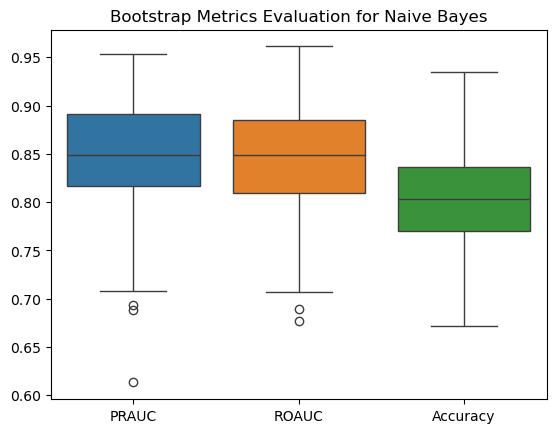

In [9]:
sns.boxplot(data=pd.DataFrame(test_metrics).melt(var_name="Metrics"), x="Metrics", y="value", hue="Metrics")
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"Bootstrap Metrics Evaluation for {method_name}")
plt.show()

### Logistic Regression

In [10]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_pred_prob = logistic.predict_proba(X_test)

In [11]:
test_metrics = bootstrap_test_from_pred(label=y_test, pred_prob=logistic_pred_prob, bootstrap_sample_size=y_test.shape[0], PRAUC=average_precision_score, ROAUC=roc_auc_score, Accuracy=accuracy_score)

In [12]:
method_name = "Logistics Regression"
print(f"Bootstrap Metrics Evaluation for {method_name}\n")
for metric, metric_res in test_metrics.items():
    print(f"{metric}:")
    print(f"Mean: {np.mean(metric_res):.3f}")
    print(f"95% CI Upper: {np.percentile(metric_res, 97.5):.3f}")
    print(f"95% CI Lower: {np.percentile(metric_res, 2.5):.3f}")
    print("*"*15)

Bootstrap Metrics Evaluation for Logistics Regression

PRAUC:
Mean: 0.842
95% CI Upper: 0.949
95% CI Lower: 0.697
***************
ROAUC:
Mean: 0.867
95% CI Upper: 0.955
95% CI Lower: 0.767
***************
Accuracy:
Mean: 0.757
95% CI Upper: 0.852
95% CI Lower: 0.639
***************


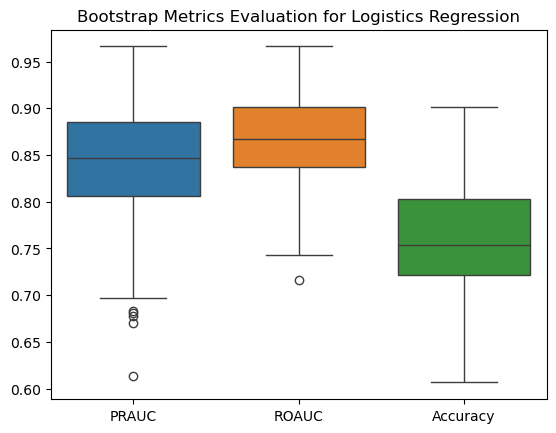

In [13]:
sns.boxplot(data=pd.DataFrame(test_metrics).melt(var_name="Metrics"), x="Metrics", y="value", hue="Metrics")
plt.xlabel(None)
plt.ylabel(None)
plt.title(f"Bootstrap Metrics Evaluation for {method_name}")
plt.show()